## Comparison

#### Preambule

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_10208\688568299.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Data reading

In [8]:
xr_dataread = xr.open_dataset("K:/ECEMF/T5.2/xr_dataread.nc")
xr_2030 = xr.open_dataset("K:/ECEMF/T5.2/xr_alloc_2030.nc")
xr_2040 = xr.open_dataset("K:/ECEMF/T5.2/xr_alloc_2040.nc")
xr_2050 = xr.open_dataset("K:/ECEMF/T5.2/xr_alloc_2050.nc")

In [3]:
df_berg = pd.read_excel(Path("X:/user/dekkerm/Data/") / "Berg_paper" / "Berg2019_data.xlsx", sheet_name = "Emission pathways")
df_berg2 = df_berg[(df_berg.Scenario == 'Gt400') & (df_berg.Category == 'Emissions|Kyoto Gases')].drop(columns=['Scenario', 'Fixed variable', 'Category', 'Unnamed: 10',  'Unnamed: 12', 'Region #'])
df_berg2 = df_berg2.rename({'Sensitivity case': "Parameters", 'Year': 'Time'}, axis=1)
approaches = np.array(df_berg2.Approach)
approaches[approaches == 'IEPC'] = 'PC'
df_berg2['Approach'] = approaches
df_berg2 = df_berg2.melt(id_vars=["Approach", "Region", "Parameters", "Time"], var_name="Range", value_name="Value")
df_berg2 = df_berg2.set_index(['Approach', "Region", "Parameters", "Range", "Time"])
xr_berg = df_berg2.to_xarray()

In [4]:
df_rob = pd.read_excel(Path("X:/user/dekkerm/Data/") / "Robiou_paper" / "Robiou2016_15data.xlsx", sheet_name = "1.5°C National allocations")
df_rob2 = df_rob.drop(columns=['Country names', 'INDC Low assessment', 'INDC average assessment', 'INDC High assessment', 2025, '2025.1', '2030.1', 2040, '2040.1', 2050, '2050.1', 'Peaking year', 'First net-zero allocation year', 'Budget 2010-2050', 'Budget 2010-2100'])
df_rob2 = df_rob2.rename({'Country code ISO Alpha-3': 'Region', "approaches names": "Approach", 2030:'Val2030wrt2010'}, axis=1)
approaches = np.array(df_rob2.Approach)
approaches[approaches == 'CER'] = 'GF'
approaches[approaches == 'EPC'] = 'PCC'
approaches[approaches == 'CAP'] = 'AP'
approaches[approaches == 'CPC'] = 'ECPC'
df_rob2['Approach'] = approaches
df_rob2 = df_rob2.set_index(['Approach', 'Region'])
xr_rob = df_rob2.to_xarray()

In [5]:
df_raj = pd.read_csv(Path("X:/user/dekkerm/Data/") / "Rajamani_paper" / "Data.csv")
df_raj2 = df_raj[df_raj.keys()[[1, -1, -2]]]
df_raj2 = df_raj2.rename({'ISO3': 'Region', 'Full literature range maximum 2030 [% of 2010]': 'Maximum_2030wrt2010', 'Full literature range minimum 2030 [% of 2010]' : 'Minimum_2030wrt2010'}, axis=1)
df_raj3 = df_raj2.melt(id_vars=["Region"], var_name="Variable", value_name="Value")
df_raj3 = df_raj3.set_index(['Variable', 'Region'])
xr_raj = df_raj3.to_xarray()

In [6]:
all_countries_iso = np.load(Path("K:/ECEMF/T5.2/") / "all_countries.npy", allow_pickle=True)

#### Check summations

In [47]:
xr_rci = xr.open_dataset("K:/ECEMF/T5.2/xr_rci.nc").load()

In [79]:
xr_rci.sel(Historical_startyear=1950, Capability_threshold='Th', RCI_weight='Half', Time=2030, Region='NLD')

<xarray.Dataset>
Dimensions:               ()
Coordinates:
    Region                <U16 'NLD'
    Time                  int32 2030
    Historical_startyear  int64 1950
    Capability_threshold  <U4 'Th'
    RCI_weight            <U4 'Half'
Data variables:
    rci                   float64 0.01101

In [78]:
(xr_rci / xr_rci.sel(Region=all_countries_iso).sum(dim='Region')).sel(Historical_startyear=1950, Capability_threshold='Th', RCI_weight='Half', Time=2030, Region='NLD')

<xarray.Dataset>
Dimensions:               ()
Coordinates:
    Region                <U16 'NLD'
    Time                  int32 2030
    Historical_startyear  int64 1950
    Capability_threshold  <U4 'Th'
    RCI_weight            <U4 'Half'
Data variables:
    rci                   float64 0.01308

(1951.0, 2030.0)

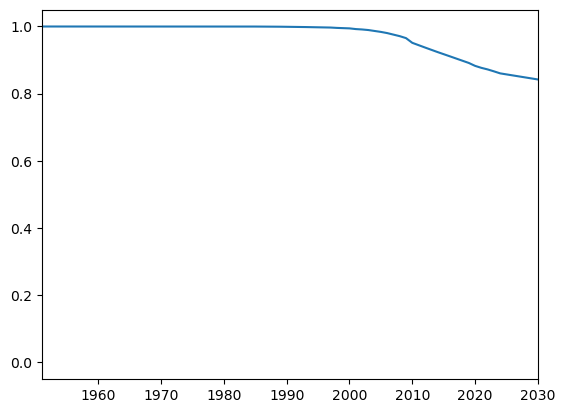

In [72]:
plt.plot(xr_rci.Time, (xr_rci.sel(Historical_startyear=1950, Capability_threshold='Th', RCI_weight='Half', Region=all_countries_iso)).sum(dim='Region').rci)
plt.xlim([1951, 2030])

In [87]:
float(xr_dataread.sel(Time=2050, Temperature=1.5, Risk=0.5, NegEmis=0.5, NonCO2red=0.5, Timing='Immediate', Scenario='SSP2').GHG_base.sel(Region='EARTH')) - float(xr_dataread.sel(Time=2050, Temperature=1.5, Risk=0.5, NegEmis=0.5, NonCO2red=0.5, Timing='Immediate', Scenario='SSP2').GHG_globe)

58037.67285376342

In [91]:
58*(1-0.845)

8.990000000000002

In [85]:
np.array(xr_dataread.sel(Time=2050, Temperature=1.5, Risk=0.5, NegEmis=0.5, NonCO2red=0.5, Timing='Immediate', Scenario='SSP2').GHG_globe)

array(3904.7971666)

In [64]:
float(xr_dataread.sel(Time=2050, Temperature=1.5, Risk=0.5, NegEmis=0.5, NonCO2red=0.5, Timing='Immediate', Scenario='SSP2').GHG_base.sel(Region='EARTH'))

61942.4700203683

In [65]:
float(xr_dataread.sel(Time=2050, Temperature=1.5, Risk=0.5, NegEmis=0.5, NonCO2red=0.5, Timing='Immediate', Scenario='SSP2', Region=all_countries_iso).GHG_base.sum(dim="Region"))

61315.4107661123

In [31]:
dict_standard = {'Temperature': 1.5, "Risk": 0.5, 'NegEmis': 0.5, "NonCO2red": 0.5, "Timing": "Immediate", 'Scenario':'SSP2', "Historical_startyear":1950, "Capability_threshold": "Th", "RCI_weight": "Half"}

In [88]:
float(xr_2030.sel(Region='EARTH', **dict_standard).GF)

28698.47265625

In [89]:
xr_2030.sel(Region=all_countries_iso, **dict_standard).sum(dim='Region').GDR

<xarray.DataArray 'GDR' ()>
array(17130.1, dtype=float32)
Coordinates:
    Scenario              <U4 'SSP2'
    Temperature           float64 1.5
    Risk                  float64 0.5
    NonCO2red             float64 0.5
    NegEmis               float64 0.5
    Timing                <U9 'Immediate'
    Historical_startyear  int64 1950
    Capability_threshold  <U4 'Th'
    RCI_weight            <U4 'Half'
    Time                  int32 ...
    source                <U25 ...
    Version               <U6 ...

#### Baseline emissions: check whether emissions add up

#### Comparison

Check the minima of the range within GF, PCC, GDR and AP for any given country (cty):

In [7]:
vary = ['GF', 'PCC', 'GDR', 'AP']
cty = 'IND'

# Own work
val_2005 = float(xr_dataread.GHG_hist.sel(Time=2010, Region=cty))
val_year = np.array(xr_2030.sel(Temperature=1.5, Risk=0.5, NegEmis=0.5, Timing='Immediate', NonCO2red=0.5, Region=cty, Convergence_year=2050).mean(dim=['Scenario'])[vary].to_array())
print('Own work:',np.round(np.min((val_year - val_2005)/val_2005), 3))

# Berg
try:
    val_2010 = np.array(xr_berg.sel(Approach=vary, Range='default', Region=cty, Time=2010).mean(dim='Parameters').Value)
    val_year = np.array(xr_berg.sel(Approach=vary, Range='default', Region=cty, Time=2030).mean(dim='Parameters').Value)
    print('Berg:',np.round(np.min((val_year - val_2010)/val_2010), 3))
except:
    3

# Robiou
val_yearwrt2010 = np.array(xr_rob.sel(Approach=vary, Region=cty).Val2030wrt2010/100)
print('Robiou (excl LULUCF):',np.round(np.min(val_yearwrt2010), 3))

# Raj
val = 1-float(xr_raj.sel(Variable = 'Minimum_2030wrt2010', Region=cty).Value)/100
print('Rajamani (excl LULUCF):',np.round(-val, 3))

Own work: -0.229
Berg: -0.315
Robiou (excl LULUCF): -0.33
Rajamani (excl LULUCF): -0.188


Also check the maximum allocation (all in 2030 wrt 2010):

In [8]:
vary = ['GF', 'PCC', 'GDR', 'AP']
cty = 'NLD'

# Own work
val_2005 = float(xr_dataread.GHG_hist.sel(Time=2010, Region=cty))
val_year = np.array(xr_2030.sel(Temperature=1.5, Risk=0.5, NegEmis=0.5, Timing='Immediate', NonCO2red=0.5, Region=cty, Convergence_year=2050).mean(dim=['Scenario'])[vary].to_array()) #Timing='Immediate',  , NonCO2red=0.5
print('Own work:',np.round(np.max((val_year - val_2005)/val_2005), 3))

# Berg
try:
    val_2010 = np.array(xr_berg.sel(Approach=vary, Range='default', Region=cty, Time=2010).mean(dim='Parameters').Value)
    val_year = np.array(xr_berg.sel(Approach=vary, Range='default', Region=cty, Time=2030).mean(dim='Parameters').Value)
    print('Berg:',np.round(np.max((val_year - val_2010)/val_2010), 3))
except:
    3

# Robiou
val_yearwrt2010 = np.array(xr_rob.sel(Approach=vary, Region=cty).Val2030wrt2010/100)
print('Robiou (excl LULUCF):',np.round(np.max(val_yearwrt2010), 3))

# Raj
val = 1-float(xr_raj.sel(Variable = 'Maximum_2030wrt2010', Region=cty).Value)/100
print('Rajamani (excl LULUCF):',np.round(-val, 3))

Own work: -0.554
Robiou (excl LULUCF): -0.33
Rajamani (excl LULUCF): -0.391


Per allocation rule (Rajamani does not provide this):

In [20]:
cty = 'NLD'

for vary in ['GF', 'PCC', 'AP', 'GDR', 'ECPC']:
    print('=========', vary, '=========')
    # Own work
    val_2005 = xr_dataread.GHG_hist.sel(Time=2010, Region=cty)
    val_year = xr_2030.sel(Temperature=1.5, Risk=0.5, NegEmis=0.5, Timing='Immediate', NonCO2red=0.5, Region=cty, Convergence_year=2050, Capability_threshold='No').mean(dim=['Scenario', 'Discount_factor', 'Historical_startyear', 'RCI_weight'])[vary] #Timing='Immediate',  , NonCO2red=0.5
    print('Own work:',np.round(float((val_year - val_2005)/val_2005), 3))

    # Berg
    try:
        val_2010 = xr_berg.sel(Approach=vary, Range='default', Region=cty, Time=2010).mean(dim='Parameters').Value
        val_year = xr_berg.sel(Approach=vary, Range='default', Region=cty, Time=2030).mean(dim='Parameters').Value
        print('Berg:',np.round(float((val_year - val_2010)/val_2010), 3))
    except:
        3

    # Robiou
    val_yearwrt2010 = float(xr_rob.sel(Approach=vary, Region=cty).Val2030wrt2010/100)
    print('Robiou (excl LULUCF):',np.round(val_yearwrt2010, 3))
    print('')

========= GF =========
Own work: -0.554
Robiou (excl LULUCF): -0.33

========= PCC =========
Own work: -0.6
Robiou (excl LULUCF): -0.58

========= AP =========
Own work: -0.765
Robiou (excl LULUCF): -0.75

========= GDR =========
Own work: -1.349
Robiou (excl LULUCF): -0.9

========= ECPC =========
Own work: -0.701
Robiou (excl LULUCF): -0.67

